## Initialise

In [47]:
import os
import joblib
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score


##  Import datasets


In [48]:
df2010census = pd.read_csv(r"C:\Users\NCzar\Documents\CitadelDataOpen\datasets\nyc_bachelors\Census_2010.csv")
df2011census = pd.read_csv(r"C:\Users\NCzar\Documents\CitadelDataOpen\datasets\nyc_bachelors\Census_2011.csv")
df2012census = pd.read_csv(r"C:\Users\NCzar\Documents\CitadelDataOpen\datasets\nyc_bachelors\Census_2012.csv")
df2013census = pd.read_csv(r"C:\Users\NCzar\Documents\CitadelDataOpen\datasets\nyc_bachelors\Census_2013.csv")
df2014census = pd.read_csv(r"C:\Users\NCzar\Documents\CitadelDataOpen\datasets\nyc_bachelors\Census_2014.csv")
df2015census = pd.read_csv(r"C:\Users\NCzar\Documents\CitadelDataOpen\datasets\nyc_bachelors\Census_2015.csv")
df2016census = pd.read_csv(r"C:\Users\NCzar\Documents\CitadelDataOpen\datasets\nyc_bachelors\Census_2016.csv")
df2017census = pd.read_csv(r"C:\Users\NCzar\Documents\CitadelDataOpen\datasets\nyc_bachelors\Census_2017.csv")
df2018census = pd.read_csv(r"C:\Users\NCzar\Documents\CitadelDataOpen\datasets\nyc_bachelors\Census_2018.csv")

# create database list for initial cleaning of all databases
dfCensusList = [df2010census,df2011census,df2012census,df2013census,df2014census,df2015census,df2016census, df2017census, df2018census]
Years = [2010,2011,2012,2013,2014,2015,2016,2017,2018]


## Adjust for inflation
Annual retail price index to measure inflation   
Organised in such a way that once 2010 is multiplied it gives house value in that year

In [49]:
RPI = np.array([1.6, 3.2, 2.1, 1.5, 1.6, 0.7, 0.2, 2.1])
RPI = (RPI/100) + 1

RPI[1] = RPI[0] * RPI[1]
RPI[2] = RPI[1] * RPI[2] 
RPI[3] = RPI[2] * RPI[3] 
RPI[4] = RPI[3] * RPI[4] 
RPI[5] = RPI[4] * RPI[5] 
RPI[6] = RPI[5] * RPI[6] 
RPI[7] = RPI[6] * RPI[7] 
# RPI = 1 - RPI
RPI = 1- (RPI-1)

RPI

array([0.984     , 0.951488  , 0.92946925, 0.91341129, 0.89602587,
       0.88829805, 0.88607464, 0.86268221])

## Find the number of people with bachelors over 25
Normalised Bachelor Over 25 Percentage = ((total bachelor) - (18-24 year old with bachelors) / (total population)) * 100

- B06009_005E - Total Bachelor's Degree
- B15001_017E - 18-24 Year Old Male Having Bachelor Degree
- B15001_050E - 18-24 Year Old Female Having Bachelor Degree  

Also remove rows which have negative house value, income, population and no.


In [50]:
index = 0
for dfYearCensus in dfCensusList:
    dfYearCensus.fillna(0)
    dfYearCensus["bachelors over 25"] = ((dfYearCensus["B06009_005E"] - dfYearCensus["B15001_017E"] - dfYearCensus["B15001_050E"]) / dfYearCensus['B01001_001E'] )*100
    dfYearCensus.drop(dfYearCensus[dfYearCensus['bachelors over 25'] <= 0].index, inplace=True)
    dfYearCensus.drop(dfYearCensus[dfYearCensus['B01001_001E'] < 0].index, inplace=True)
    dfYearCensus.drop(dfYearCensus[dfYearCensus['B19013_001E'] < 0].index, inplace=True)
    dfYearCensus.drop(dfYearCensus[dfYearCensus['B25077_001E'] < 0].index, inplace=True)
    dfCensusList[index] = dfYearCensus
    index += 1

## Rename columns to make them readable

In [51]:
df2010census.columns = ['geoid', 'year', 'name', '2010population', '2010household_income', '2010home_value', 
                        '2010no_nonh_caucasians', '2010no_nonh_blacks/aas', '2010no_amerinds_alskns', '2010no_nonh_asians',
                        '2010no_nonh_hawaii_pacific', '2010no_nonh_others', '2010no_nonh_multi', '2010no_hisp_latin','2010total bachelors','2010male bachelors 18-24' ,'2010female bachelors 18-24','state', 'county', 'tract', '2010bachelor over 25']


df2011census.columns = ['geoid', 'year', 'name', '2011population', '2011household_income', '2011home_value', 
                        '2011no_nonh_caucasians', '2011no_nonh_blacks/aas', '2011no_amerinds_alskns', '2011no_nonh_asians',
                        '2011no_nonh_hawaii_pacific', '2011no_nonh_others', '2011no_nonh_multi', '2011no_hisp_latin','2011total bachelors','2011male bachelors 18-24' ,'2011female bachelors 18-24','state', 'county', 'tract', '2011bachelor over 25']


df2012census.columns = ['geoid', 'year', 'name', '2012population', '2012household_income', '2012home_value', 
                        '2012no_nonh_caucasians', '2012no_nonh_blacks/aas', '2012no_amerinds_alskns', '2012no_nonh_asians',
                        '2012no_nonh_hawaii_pacific', '2012no_nonh_others', '2012no_nonh_multi', '2012no_hisp_latin','2012total bachelors','2012male bachelors 18-24' ,'2012female bachelors 18-24','state', 'county', 'tract', '2012bachelor over 25']


df2013census.columns = ['geoid', 'year', 'name', '2013population', '2013household_income', '2013home_value', 
                        '2013no_nonh_caucasians', '2013no_nonh_blacks/aas', '2013no_amerinds_alskns', '2013no_nonh_asians',
                        '2013no_nonh_hawaii_pacific', '2013no_nonh_others', '2013no_nonh_multi', '2013no_hisp_latin','2013total bachelors','2013male bachelors 18-24' ,'2013female bachelors 18-24','state', 'county', 'tract', '2013bachelor over 25']


df2014census.columns = ['geoid', 'year', 'name', '2014population', '2014household_income', '2014home_value', 
                        '2014no_nonh_caucasians', '2014no_nonh_blacks/aas', '2014no_amerinds_alskns', '2014no_nonh_asians',
                        '2014no_nonh_hawaii_pacific', '2014no_nonh_others', '2014no_nonh_multi', '2014no_hisp_latin','2014total bachelors','2014male bachelors 18-24' ,'2014female bachelors 18-24','state', 'county', 'tract', '2014bachelor over 25']


df2015census.columns = [ 'geoid', 'year', 'name', '2015population', '2015household_income', '2015home_value', 
                        '2015no_nonh_caucasians', '2015no_nonh_blacks/aas', '2015no_amerinds_alskns', '2015no_nonh_asians',
                        '2015no_nonh_hawaii_pacific', '2015no_nonh_others', '2015no_nonh_multi', '2015no_hisp_latin','2015total bachelors','2015male bachelors 18-24' ,'2015female bachelors 18-24','state', 'county', 'tract', '2015bachelor over 25']


df2016census.columns = ['geoid', 'year', 'name', '2016population', '2016household_income', '2016home_value', 
                        '2016no_nonh_caucasians', '2016no_nonh_blacks/aas', '2016no_amerinds_alskns', '2016no_nonh_asians',
                        '2016no_nonh_hawaii_pacific', '2016no_nonh_others', '2016no_nonh_multi', '2016no_hisp_latin','2016total bachelors','2016male bachelors 18-24' ,'2016female bachelors 18-24','state', 'county', 'tract', '2016bachelor over 25']


df2017census.columns = [ 'geoid', 'year', 'name', '2017population', '2017household_income', '2017home_value', 
                        '2017no_nonh_caucasians', '2017no_nonh_blacks/aas', '2017no_amerinds_alskns', '2017no_nonh_asians',
                        '2017no_nonh_hawaii_pacific', '2017no_nonh_others', '2017no_nonh_multi', '2017no_hisp_latin','2017total bachelors','2017male bachelors 18-24' ,'2017female bachelors 18-24','state', 'county', 'tract', '2017bachelor over 25']


df2018census.columns = [ 'geoid', 'year', 'name', '2018population', '2018household_income', '2018home_value', 
                        '2018no_nonh_caucasians', '2018no_nonh_blacks/aas', '2018no_amerinds_alskns', '2018no_nonh_asians',
                        '2018no_nonh_hawaii_pacific', '2018no_nonh_others', '2018no_nonh_multi', '2018no_hisp_latin','2018total bachelors','2018male bachelors 18-24' ,'2018female bachelors 18-24','state', 'county', 'tract', '2018bachelor over 25']





## Merge dataframes
- Set index of dataframes as geoid because it is unique for each tract

In [52]:
for dfYearCensus in dfCensusList:
        dfYearCensus.set_index('geoid')
        dfYearCensus.sort_values('geoid')

census_data = pd.concat([df2010census, df2011census, df2012census, df2013census, df2014census, df2015census,
                       df2016census, df2017census, df2018census], axis=1)

census_data_copy = census_data.copy()


### Gentrification-eligible tracts were determined to have gentrified over a time period if they met the following criteria:

- An increase in a tract's educational attainment, as measured by the percentage of residents age 25 and over holding bachelor’s degrees, was in the top third percentile of all tracts within a metro area.
- A tract’s median home value increased when adjusted for inflation.
- The percentage increase in a tract’s inflation-adjusted median home value was in the top third percentile of all tracts within a metro area

## Test the FIRST criteria for whether an area has been GENTRIFIED
An increase in a tract's educational attainment, as measured by the percentage of residents age 25 and over holding bachelor’s degrees, was in the top third percentile of all tracts within a metro area.

In [53]:
# Find percentage increase
for j in range(0,len(RPI)):
    census_data["{Year}percent_inc_bachelor_over_25".format(Year = Years[j+1])] = ((census_data["{Year}bachelor over 25".format(Year = Years[j+1])] - census_data['2010bachelor over 25']))

# Find percentile
percentile_inc_bachelor_over_25 = np.zeros(8)
for j in range(0,len(RPI)):
    percentile_inc_bachelor_over_25[j] = census_data['{Year}percent_inc_bachelor_over_25'.format(Year = Years[j+1])].quantile(0.66666666666)

# See whether there has been the % increase required
for j in range(0,len(RPI)):
    census_data["{Year}inc_bachelors_in_3_percentile".format(Year = Years[j+1])] = np.where((census_data["{Year}percent_inc_bachelor_over_25".format(Year = Years[j+1])] >= percentile_inc_bachelor_over_25[j]), 1, 0)


Array showing the 66th percentile change for each year compared to 2010

In [54]:
percentile_inc_bachelor_over_25

array([1.50359421, 2.39472863, 2.76116016, 2.42923733, 3.05005035,
       3.27555353, 4.34525425, 4.75526966])

## Test the SECOND criteria for whether an area has been GENTRIFIED
A tract’s median home value increased when adjusted for inflation.


In [55]:
# Adjust for inflation
for j in range(0,len(RPI)):
    census_data["{Year}adjusted_house_value".format(Year = Years[j+1])] = census_data["{Year}home_value".format(Year = Years[j+1])] * RPI[j]

# See whether there has been an increase
for j in range(0,len(RPI)):
    census_data["{Year}increase_in_home_value".format(Year = Years[j+1])] = np.where((census_data["{Year}adjusted_house_value".format(Year = Years[j+1])] > census_data['2010home_value']), 1, 0)

## Test the THIRD criteria for whether an area has been GENTRIFIED
The percentage increase in a tract’s inflation-adjusted median home value was in the top third percentile of all tracts within a metro area.

In [56]:
# Initialise percentile array for each year
percentile_increase_house_value = np.zeros(8)

for j in range(0,len(RPI)):
    # Find increase
    census_data["{Year}percent_inc_house_value".format(Year = Years[j+1])] = ((census_data["{Year}adjusted_house_value".format(Year = Years[j+1])] - census_data      ['2010home_value']) / census_data['2010home_value']) * 100

    census_data.drop(census_data[census_data["{Year}percent_inc_house_value".format(Year = Years[j+1])] < 0].index, inplace=True)

    # Find percentile
    percentile_increase_house_value[j] = census_data['{Year}percent_inc_house_value'.format(Year = Years[j+1])].quantile(0.666666666666)

    # See whether there has been the % increase required
    census_data["{Year}inc_house_value_in_3_percentile".format(Year = Years[j+1])] = np.where((census_data["{Year}percent_inc_house_value".format(Year = Years[j+1])] >= percentile_increase_house_value[j]) , 1, 0)


Array showing the 66th percentile change for each year compared to 2010

In [57]:
print(percentile_increase_house_value)

[ 42.16182359  54.93581659  55.40584063  72.45051377 100.9525203
 107.5803091  134.74201308 148.95514228]


## Combine all the 3 tests for whether gentrified
Create new column for each year stating whether it has been gentrified compared to 2010

In [58]:
# See whether gentrified
for j in range(0,len(RPI)):
    census_data["{Year}gentrified".format(Year = Years[j+1])] = np.where((census_data["{Year}inc_house_value_in_3_percentile".format(Year = Years[j+1])] == 1) & (census_data["{Year}increase_in_home_value".format(Year = Years[j+1])] == 1) & (census_data["{Year}inc_bachelors_in_3_percentile".format(Year = Years[j+1])] == 1), 1, 0)


Plot a bar chart showing how many have been gentrified for each year

<BarContainer object of 8 artists>

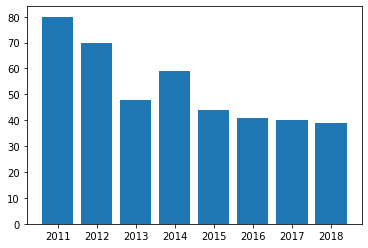

In [59]:
gentrified_number = np.zeros(8)
for j in range(0,len(RPI)):
    gentrified_number[j] = np.count_nonzero(census_data['{Year}gentrified'.format(Year = Years[j+1])])

plt.bar(Years[1:],gentrified_number)


## Whether eligable to be considered for gentrification

The first test found that a tract was eligible to gentrify if it met the following criteria:

- The tract had a population of at least 500 residents at the beginning and end of a decade and was located within a central city. 
- The tract’s median household income was in the bottom 40th percentile when compared to all tracts within its metro area at the beginning of the decade.
- The tract’s median home value was in the bottom 40th percentile when compared to all tracts within its metro area at the beginning of the decade.  

Also export the eligibility for gentrification column

In [60]:
census_data_copy['gentrify_elig'] = 0
census_data_copy['2010_population_greater_500'] = 0

income_40_percentile = census_data_copy['2010household_income'].quantile(0.4)
value_40_percentile = census_data_copy['2010home_value'].quantile(0.4)

census_data_copy.loc[(census_data_copy['2010household_income'] <= income_40_percentile) & 
               (census_data_copy['2010home_value'] <= value_40_percentile) &
               (census_data_copy['2010population'] >= 500), 'gentrify_elig'] = 1

census_data_copy = census_data_copy[['geoid','gentrify_elig']]
census_data = pd.concat([census_data, census_data_copy], axis=1)


## See what tracts were eligible for gentrification and have been classed as gentrified

In [61]:
for j in range(0,len(RPI)):
    census_data["{Year}gentrified_and_eligable".format(Year = Years[j+1])] = np.where((census_data["gentrify_elig"] ==1) & (census_data['{Year}gentrified'.format(Year = Years[j+1])] == 1) , 1, 0)

### Create bar chart showing how many have gentrified over time compared to 2010

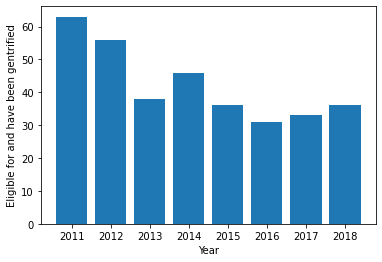

In [62]:
gentrified_number_and_eligable = np.zeros(8)
for j in range(0,len(RPI)):
    gentrified_number_and_eligable[j] = np.count_nonzero(census_data['{Year}gentrified_and_eligable'.format(Year = Years[j+1])])


plt.bar(Years[1:],gentrified_number_and_eligable)
plt.xlabel('Year')
plt.ylabel('Eligible for and have been gentrified')
plt.show()

In [63]:
gentrified_number_and_eligable

array([63., 56., 38., 46., 36., 31., 33., 36.])

## Modeling using all data
Using Random Forest algorithm  
- Input data = All the census_data except the tract names and other string variables
- Output data = Gentrified and eligible

In [64]:
census_data = census_data.fillna(0)

census_data_x = census_data[['2010population', '2010household_income', '2010home_value', 
                        '2010no_nonh_caucasians', '2010no_nonh_blacks/aas', '2010no_amerinds_alskns', '2010no_nonh_asians',
                        '2010no_nonh_hawaii_pacific', '2010no_nonh_others', '2010no_nonh_multi', '2010no_hisp_latin','2010total bachelors','2010bachelor over 25',

                        '2012population', '2012household_income', '2012home_value', 
                        '2012no_nonh_caucasians', '2012no_nonh_blacks/aas', '2012no_amerinds_alskns', '2012no_nonh_asians',
                        '2012no_nonh_hawaii_pacific', '2012no_nonh_others', '2012no_nonh_multi', '2012no_hisp_latin','2012total bachelors','2012male bachelors 18-24' ,'2012female bachelors 18-24', '2012bachelor over 25',

                         '2013population', '2013household_income', '2013home_value', 
                        '2013no_nonh_caucasians', '2013no_nonh_blacks/aas', '2013no_amerinds_alskns', '2013no_nonh_asians',
                        '2013no_nonh_hawaii_pacific', '2013no_nonh_others', '2013no_nonh_multi', '2013no_hisp_latin','2013total bachelors','2013male bachelors 18-24' ,'2013female bachelors 18-24', '2013bachelor over 25',

                        '2014population', '2014household_income', '2014home_value', 
                        '2014no_nonh_caucasians', '2014no_nonh_blacks/aas', '2014no_amerinds_alskns', '2014no_nonh_asians',
                        '2014no_nonh_hawaii_pacific', '2014no_nonh_others', '2014no_nonh_multi', '2014no_hisp_latin','2014total bachelors','2014male bachelors 18-24' ,'2014female bachelors 18-24', '2014bachelor over 25',
                        '2015population', '2015household_income', '2015home_value', 
                        '2015no_nonh_caucasians', '2015no_nonh_blacks/aas', '2015no_amerinds_alskns', '2015no_nonh_asians',
                        '2015no_nonh_hawaii_pacific', '2015no_nonh_others', '2015no_nonh_multi', '2015no_hisp_latin','2015total bachelors','2015male bachelors 18-24' ,'2015female bachelors 18-24', '2015bachelor over 25',

                        '2016population', '2016household_income', '2016home_value', 
                        '2016no_nonh_caucasians', '2016no_nonh_blacks/aas', '2016no_amerinds_alskns', '2016no_nonh_asians',
                        '2016no_nonh_hawaii_pacific', '2016no_nonh_others', '2016no_nonh_multi', '2016no_hisp_latin','2016total bachelors','2016male bachelors 18-24' ,'2016female bachelors 18-24', '2016bachelor over 25',

                        '2017population', '2017household_income', '2017home_value', 
                        '2017no_nonh_caucasians', '2017no_nonh_blacks/aas', '2017no_amerinds_alskns', '2017no_nonh_asians',
                        '2017no_nonh_hawaii_pacific', '2017no_nonh_others', '2017no_nonh_multi', '2017no_hisp_latin','2017total bachelors','2017male bachelors 18-24' ,'2017female bachelors 18-24', '2017bachelor over 25',

                         '2018population', '2018household_income', '2018home_value', 
                        '2018no_nonh_caucasians', '2018no_nonh_blacks/aas', '2018no_amerinds_alskns', '2018no_nonh_asians',
                        '2018no_nonh_hawaii_pacific', '2018no_nonh_others', '2018no_nonh_multi', '2018no_hisp_latin','2018total bachelors','2018male bachelors 18-24' ,'2018female bachelors 18-24','2018bachelor over 25']]


chosen_target = ['2018gentrified_and_eligable']

census_data_y = census_data[chosen_target]
forest_clf = RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=3,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=10, n_jobs=None, oob_score=False,
                       random_state=42, verbose=0, warm_start=False)
forest_clf.fit(census_data_x, census_data_y)
forest_scores = cross_val_score(forest_clf, census_data_x, census_data_y, cv=5)
forest_scores.mean()



0.9923422343817124

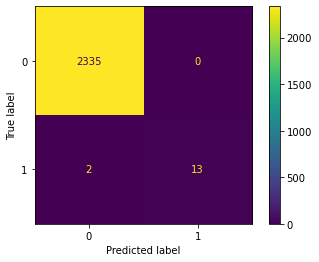

In [65]:
# Confusion matrix
census_data_sample = pd.concat([census_data_x,census_data_y], axis=1)
census_data_sample = census_data_sample.sample(frac = 0.5)

census_data_x_sample = census_data_sample.drop(columns=chosen_target)
census_data_y_sample = census_data_sample[chosen_target]
census_data_pedicted = forest_clf.predict(census_data_x_sample)

sklearn.metrics.plot_confusion_matrix(forest_clf, census_data_x_sample, census_data_y_sample)




In [66]:
forest_predictions = cross_val_predict(forest_clf, census_data_x, census_data_y, cv=5)
conf_mx = confusion_matrix(forest_predictions, census_data_y)
conf_mx

array([[4659,   30],
       [   6,    6]], dtype=int64)

In [67]:
nyc_predictions = forest_clf.predict(census_data_x)
census_data_y_list = census_data_y.values.tolist()
f1_scor = f1_score(nyc_predictions, census_data_y_list)
f1_scor

0.9253731343283582

In [68]:

precision = precision_score(nyc_predictions, census_data_y_list)
precision

0.8611111111111112

In [69]:
recall_scor = recall_score(nyc_predictions, census_data_y_list)
recall_scor

1.0

In [70]:
corr_matrix = census_data_sample.corr()
corr_matrix["2018gentrified_and_eligable"].sort_values(ascending=False)

2018gentrified_and_eligable    1.000000
2010no_hisp_latin              0.448219
2010population                 0.405646
2018bachelor over 25           0.343519
2018home_value                 0.331205
                                 ...   
2013no_nonh_hawaii_pacific    -0.002222
2010no_nonh_hawaii_pacific    -0.003042
2012no_nonh_hawaii_pacific    -0.003131
2017no_nonh_hawaii_pacific    -0.003153
2014no_nonh_hawaii_pacific    -0.003974
Name: 2018gentrified_and_eligable, Length: 119, dtype: float64

### See which features where the most relevant

In [71]:
from sklearn.ensemble import RandomForestRegressor
X = census_data_x
Y = census_data_y
names = census_data_x.columns
rf = RandomForestRegressor()
rf.fit(X, Y)
print ("Features sorted by their score:")
print (sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), names), 
             reverse=True))

Features sorted by their score:
[(0.1402, '2010population'), (0.1156, '2018home_value'), (0.0786, '2010no_hisp_latin'), (0.0535, '2018bachelor over 25'), (0.0511, '2010home_value'), (0.0478, '2010household_income'), (0.0414, '2010no_nonh_blacks/aas'), (0.0225, '2018household_income'), (0.0221, '2018no_nonh_caucasians'), (0.0177, '2010no_nonh_multi'), (0.0168, '2014home_value'), (0.0167, '2014household_income'), (0.0145, '2018female bachelors 18-24'), (0.0139, '2010no_nonh_asians'), (0.0128, '2010bachelor over 25'), (0.0126, '2016household_income'), (0.0112, '2017no_amerinds_alskns'), (0.0112, '2010total bachelors'), (0.011, '2012no_nonh_blacks/aas'), (0.01, '2018no_nonh_multi'), (0.0093, '2013no_nonh_multi'), (0.0092, '2013no_nonh_others'), (0.0077, '2016female bachelors 18-24'), (0.0076, '2012no_nonh_caucasians'), (0.0074, '2010no_nonh_caucasians'), (0.0071, '2018male bachelors 18-24'), (0.0066, '2014no_nonh_blacks/aas'), (0.006, '2010no_nonh_others'), (0.0059, '2016no_amerinds_alskns

## Modeling using only race data for each year
Using Random Forest algorithm  
- Input data = Only the race data for each year
- Output data = Gentrified and eligible

In [72]:
census_data = census_data.fillna(0)

census_data_x = census_data[[
                        '2010no_nonh_caucasians', '2010no_nonh_blacks/aas', '2010no_amerinds_alskns', '2010no_nonh_asians',
                        '2010no_nonh_hawaii_pacific', '2010no_nonh_others', '2010no_nonh_multi', '2010no_hisp_latin',

                        '2012no_nonh_caucasians', '2012no_nonh_blacks/aas', '2012no_amerinds_alskns', '2012no_nonh_asians',
                        '2012no_nonh_hawaii_pacific', '2012no_nonh_others', '2012no_nonh_multi', '2012no_hisp_latin',
                       
                        '2013no_nonh_caucasians', '2013no_nonh_blacks/aas', '2013no_amerinds_alskns', '2013no_nonh_asians',
                        '2013no_nonh_hawaii_pacific', '2013no_nonh_others', '2013no_nonh_multi', '2013no_hisp_latin',

                        '2014no_nonh_caucasians', '2014no_nonh_blacks/aas', '2014no_amerinds_alskns', '2014no_nonh_asians',
                        '2014no_nonh_hawaii_pacific', '2014no_nonh_others', '2014no_nonh_multi', '2014no_hisp_latin',
            
                        '2015no_nonh_caucasians', '2015no_nonh_blacks/aas', '2015no_amerinds_alskns', '2015no_nonh_asians',
                        '2015no_nonh_hawaii_pacific', '2015no_nonh_others', '2015no_nonh_multi', '2015no_hisp_latin',

                        '2016no_nonh_caucasians', '2016no_nonh_blacks/aas', '2016no_amerinds_alskns', '2016no_nonh_asians',
                        '2016no_nonh_hawaii_pacific', '2016no_nonh_others', '2016no_nonh_multi', '2016no_hisp_latin',

                        '2017no_nonh_caucasians', '2017no_nonh_blacks/aas', '2017no_amerinds_alskns', '2017no_nonh_asians',
                        '2017no_nonh_hawaii_pacific', '2017no_nonh_others', '2017no_nonh_multi', '2017no_hisp_latin',
              
                        '2018no_nonh_caucasians', '2018no_nonh_blacks/aas', '2018no_amerinds_alskns', '2018no_nonh_asians',
                        '2018no_nonh_hawaii_pacific', '2018no_nonh_others', '2018no_nonh_multi', '2018no_hisp_latin']]



census_data_y = census_data['2018gentrified_and_eligable']
forest_clf = RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=3,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=10, n_jobs=None, oob_score=False,
                       random_state=42, verbose=0, warm_start=False)
forest_clf.fit(census_data_x, census_data_y)
forest_scores = cross_val_score(forest_clf, census_data_x, census_data_y, cv=5)
forest_scores.mean()



0.9917039365093719

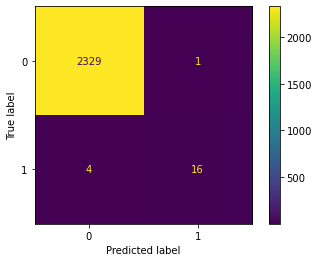

In [73]:
# Confusion matrix

census_data_sample = pd.concat([census_data_x,census_data_y], axis=1)
census_data_sample = census_data_sample.sample(frac = 0.5)

census_data_x_sample = census_data_sample.drop(columns=chosen_target)
census_data_y_sample = census_data_sample[chosen_target]
census_data_pedicted = forest_clf.predict(census_data_x_sample)

sklearn.metrics.plot_confusion_matrix(forest_clf, census_data_x_sample, census_data_y_sample)



f1Score for race as input

In [75]:
nyc_predictions = forest_clf.predict(census_data_x)
census_data_y_list = census_data_y.values.tolist()
f1_scr = f1_score(nyc_predictions, census_data_y_list)
f1_scr

0.8695652173913043

recall score for race as input

In [76]:
recall_scr = recall_score(nyc_predictions, census_data_y_list)
recall_scr

0.9090909090909091

precision of model using race as input

In [77]:
precision = precision_score(nyc_predictions, census_data_y_list)
precision

0.8333333333333334

### See which features where the most relevant

In [78]:
X = census_data_x
Y = census_data_y
names = census_data_x.columns
rf = RandomForestRegressor()
rf.fit(X, Y)
print ("Features sorted by their score:")
print (sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), names), 
             reverse=True))

Features sorted by their score:
[(0.1445, '2010no_hisp_latin'), (0.0988, '2010no_nonh_blacks/aas'), (0.0956, '2018no_nonh_caucasians'), (0.0395, '2010no_nonh_multi'), (0.0346, '2010no_nonh_caucasians'), (0.0313, '2012no_nonh_blacks/aas'), (0.0307, '2016no_nonh_asians'), (0.0299, '2010no_nonh_asians'), (0.0293, '2018no_nonh_multi'), (0.0235, '2012no_nonh_caucasians'), (0.021, '2013no_nonh_blacks/aas'), (0.0193, '2013no_nonh_caucasians'), (0.0192, '2012no_nonh_asians'), (0.0167, '2015no_nonh_caucasians'), (0.0142, '2018no_nonh_asians'), (0.0138, '2017no_amerinds_alskns'), (0.0133, '2010no_amerinds_alskns'), (0.0131, '2014no_hisp_latin'), (0.0127, '2016no_nonh_multi'), (0.0126, '2010no_nonh_others'), (0.0118, '2012no_hisp_latin'), (0.0117, '2013no_nonh_multi'), (0.0114, '2016no_hisp_latin'), (0.0113, '2018no_hisp_latin'), (0.0102, '2012no_nonh_multi'), (0.01, '2012no_amerinds_alskns'), (0.0098, '2018no_nonh_blacks/aas'), (0.0098, '2014no_amerinds_alskns'), (0.0093, '2015no_nonh_multi'), (